In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import calc_volume, calc_diameter, kde_from_sample, interpolate_ages

In [3]:
d1 = 1
v1 = calc_volume(d1)
median_doubling_time = 811
rdt = 365 / median_doubling_time
interval = 9.0
doublings = interval * rdt
v2 = v1 * 2**doublings
d2 = calc_diameter(v2)

In [4]:
v2, d2

(8.676351488087187, 2.5494480788327483)

In [5]:
rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]
rdt_sample = np.array(rdts)

<AxesSubplot:>

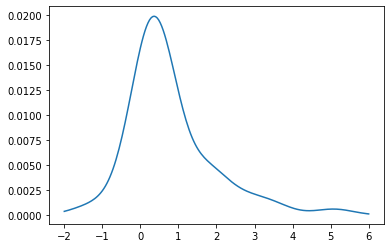

In [6]:
qs = np.linspace(-2, 6, 201)
pmf_rdt = kde_from_sample(rdt_sample, qs)
pmf_rdt.plot()

In [7]:
interval = 1
min_diameter = 0.3
max_diameter = 20

In [8]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

In [9]:
def simulate_growth(pmf_rdt):
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break

        rdt = pmf_rdt.choice()
        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

In [10]:
sim = simulate_growth(pmf_rdt)
sim.head(), sim.tail()

(   age    volume  diameter
 0    0  0.014137  0.300000
 1    1  0.007472  0.242552
 2    2  0.008824  0.256382
 3    3  0.010136  0.268508
 4    4  0.010421  0.271001,
     age       volume   diameter
 31   31  1484.371865  14.152984
 32   32  1958.640419  15.523347
 33   33  1658.469593  14.685981
 34   34  1365.900659  13.765970
 35   35  4626.279922  20.673361)

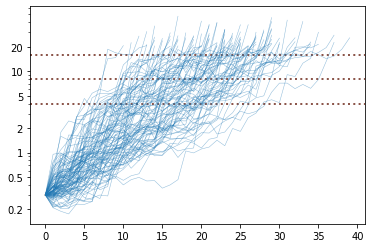

In [11]:
sims = [simulate_growth(pmf_rdt) for _ in range(101)]
for diameter in [4, 8, 16]:
    plt.axhline(diameter, color='C5', linewidth=2, ls=':')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'], color='C0', linewidth=0.5, alpha=0.5)

plt.yscale('log')
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks)
plt.show()

In [15]:
ages = interpolate_ages(sims, 15)
cdf = Cdf.from_seq(ages)
cdf.median(), cdf.credible_interval(0.9), cdf(9.0)

(array(22.1848746), array([12.47131315, 30.63913905]), array(0.))

In [17]:
import pymc3 as pm
import arviz as az

In [18]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

In [21]:
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc", mu=2 * billion, sd=0.4 * billion)
    shaker1_vol = pm.Normal("shaker1 vol", mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", mu=9.0, sd=0.05)
    yeast_slurry_vol = pm.Normal("yeast slurry vol", mu=1.0, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2", mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3", mu=1.0, sd=0.01)
    dilution_shaker1 = (yeast_slurry_vol / (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / (shaker2_to_shaker3_vol + shaker3_vol))
    final_dilution = (dilution_shaker1 * dilution_shaker2 * dilution_shaker3)
    chamber_vol = pm.Gamma("chamber_vol", mu=0.0001, sd=0.0001 / 20)
    yeast_in_chamber = pm.Poisson("yeast in chamber", mu=yeast_conc * final_dilution * chamber_vol)
    count = pm.Binomial("count", n=yeast_in_chamber, p=squares_counted/total_squares, observed=yeast_counted)

In [22]:
options = dict(return_inferencedata=False)
with model:
    trace = pm.sample(100, **options)

Only 100 samples in chain.
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [chamber_vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry vol, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]
>Metropolis: [yeast in chamber]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 44 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


In [23]:
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
cdf_pymc.mean(), cdf_pymc.credible_interval(0.9)

(2.2020934245049184, array([1.80528865, 2.62749157]))